In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

2024-08-06 22:08:48.417464: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
def pad_and_resize(img, target_size):
    old_size = img.size
    ratio = float(target_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    img = img.resize(new_size, image.ANTIALIAS)
    new_img = image.new("RGB", (target_size, target_size))
    new_img.paste(img, ((target_size - new_size[0]) // 2, (target_size - new_size[1]) // 2))
    return new_img

class CustomImageDataGenerator(ImageDataGenerator):
    def __init__(self, target_size, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.target_size = target_size

    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = []
        batch_y = []
        for i, j in enumerate(index_array):
            img_path = self.filepaths[j]
            img = image.load_img(img_path)
            img = pad_and_resize(img, self.target_size[0])
            img = image.img_to_array(img)
            img = self.random_transform(img)
            img = self.standardize(img)
            batch_x.append(img)
            batch_y.append(self.labels[j])
        return np.array(batch_x), np.array(batch_y)

data_dir = '../data/mini/'

img_height, img_width = 256, 256

train_datagen = CustomImageDataGenerator(
    target_size=(img_height, img_width),
    rescale=1./255,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 1285 images belonging to 6 classes.
Found 319 images belonging to 6 classes.


In [ ]:
def plot_sample_images(data_generator, num_classes=11):
    class_indices = list(data_generator.class_indices.values())[:num_classes]
    class_labels = list(data_generator.class_indices.keys())[:num_classes]

    fig, axes = plt.subplots(num_classes, 1, figsize=(6, num_classes * 3))
    for i, (label, idx) in enumerate(zip(class_labels, class_indices)):
        for images, labels in data_generator:
            if np.argmax(labels[0]) == idx:
                axes[i].imshow(images[0])
                axes[i].set_title(label)
                axes[i].axis('off')
                break
    plt.tight_layout()
    plt.show()

plot_sample_images(train_generator)

In [ ]:
def build_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

input_shape = (img_height, img_width, 3)
num_classes = len(train_generator.class_indices)

model = build_model(input_shape, num_classes)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

2024-08-06 22:09:01.974221: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 256)      0

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
]

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks
)

print("Training History Keys:", history.history.keys())
print("Final training accuracy: ", history.history['accuracy'][-1])
print("Final validation accuracy: ", history.history['val_accuracy'][-1])
print("Final training loss: ", history.history['loss'][-1])
print("Final validation loss: ", history.history['val_loss'][-1])

2024-08-06 22:09:20.022209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/10
15/41 [=========>....................] - ETA: 2:16 - loss: 3.1911 - accuracy: 0.1744

/home/abdulah/anaconda3/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


41/41 [==============================] - ETA: 0s - loss: 2.2487 - accuracy: 0.2529

2024-08-06 22:13:14.822910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


41/41 [==============================] - 260s 6s/step - loss: 2.2487 - accuracy: 0.2529 - val_loss: 1.6385 - val_accuracy: 0.3762 - lr: 0.0010
Epoch 2/10
41/41 [==============================] - 236s 6s/step - loss: 1.5399 - accuracy: 0.4140 - val_loss: 1.3978 - val_accuracy: 0.4702 - lr: 0.0010
Epoch 3/10
41/41 [==============================] - 239s 6s/step - loss: 1.2744 - accuracy: 0.5463 - val_loss: 1.2653 - val_accuracy: 0.5705 - lr: 0.0010
Epoch 4/10
41/41 [==============================] - 240s 6s/step - loss: 1.0651 - accuracy: 0.6156 - val_loss: 1.0378 - val_accuracy: 0.6238 - lr: 0.0010
Epoch 5/10
41/41 [==============================] - 239s 6s/step - loss: 0.8834 - accuracy: 0.6911 - val_loss: 1.0196 - val_accuracy: 0.6834 - lr: 0.0010
Epoch 6/10
41/41 [==============================] - 238s 6s/step - loss: 0.7951 - accuracy: 0.7339 - val_loss: 1.1392 - val_accuracy: 0.6301 - lr: 0.0010
Epoch 7/10
41/41 [==============================] - 245s 6s/step - loss: 0.6853 - accur

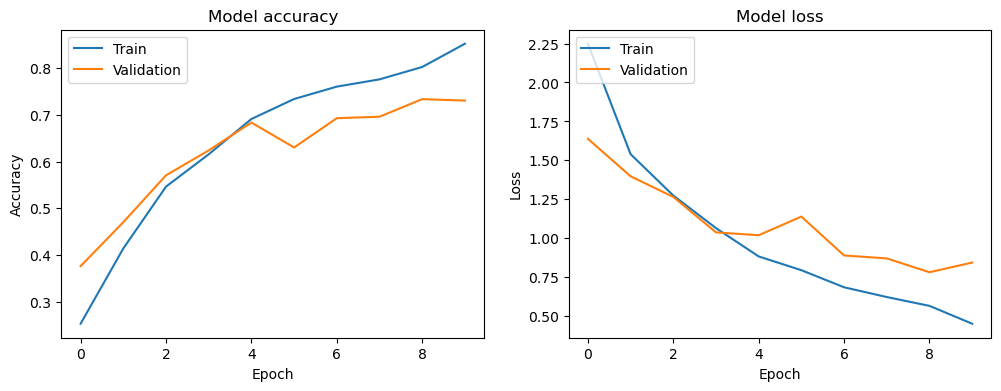

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
validation_generator.reset()
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

2024-08-06 22:50:52.608563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 33s 2s/step


In [ ]:
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

Classification Report:
                       precision    recall  f1-score   support

              Cat_Cow       0.17      0.13      0.15        47
    Lord_of_the_Dance       0.09      0.09      0.09        46
                 Plow       0.12      0.11      0.11        45
           Side_Plank       0.12      0.15      0.14        53
              Sitting       0.23      0.24      0.23        76
Standing_Forward_Bend       0.17      0.17      0.17        52

             accuracy                           0.16       319
            macro avg       0.15      0.15      0.15       319
         weighted avg       0.16      0.16      0.16       319



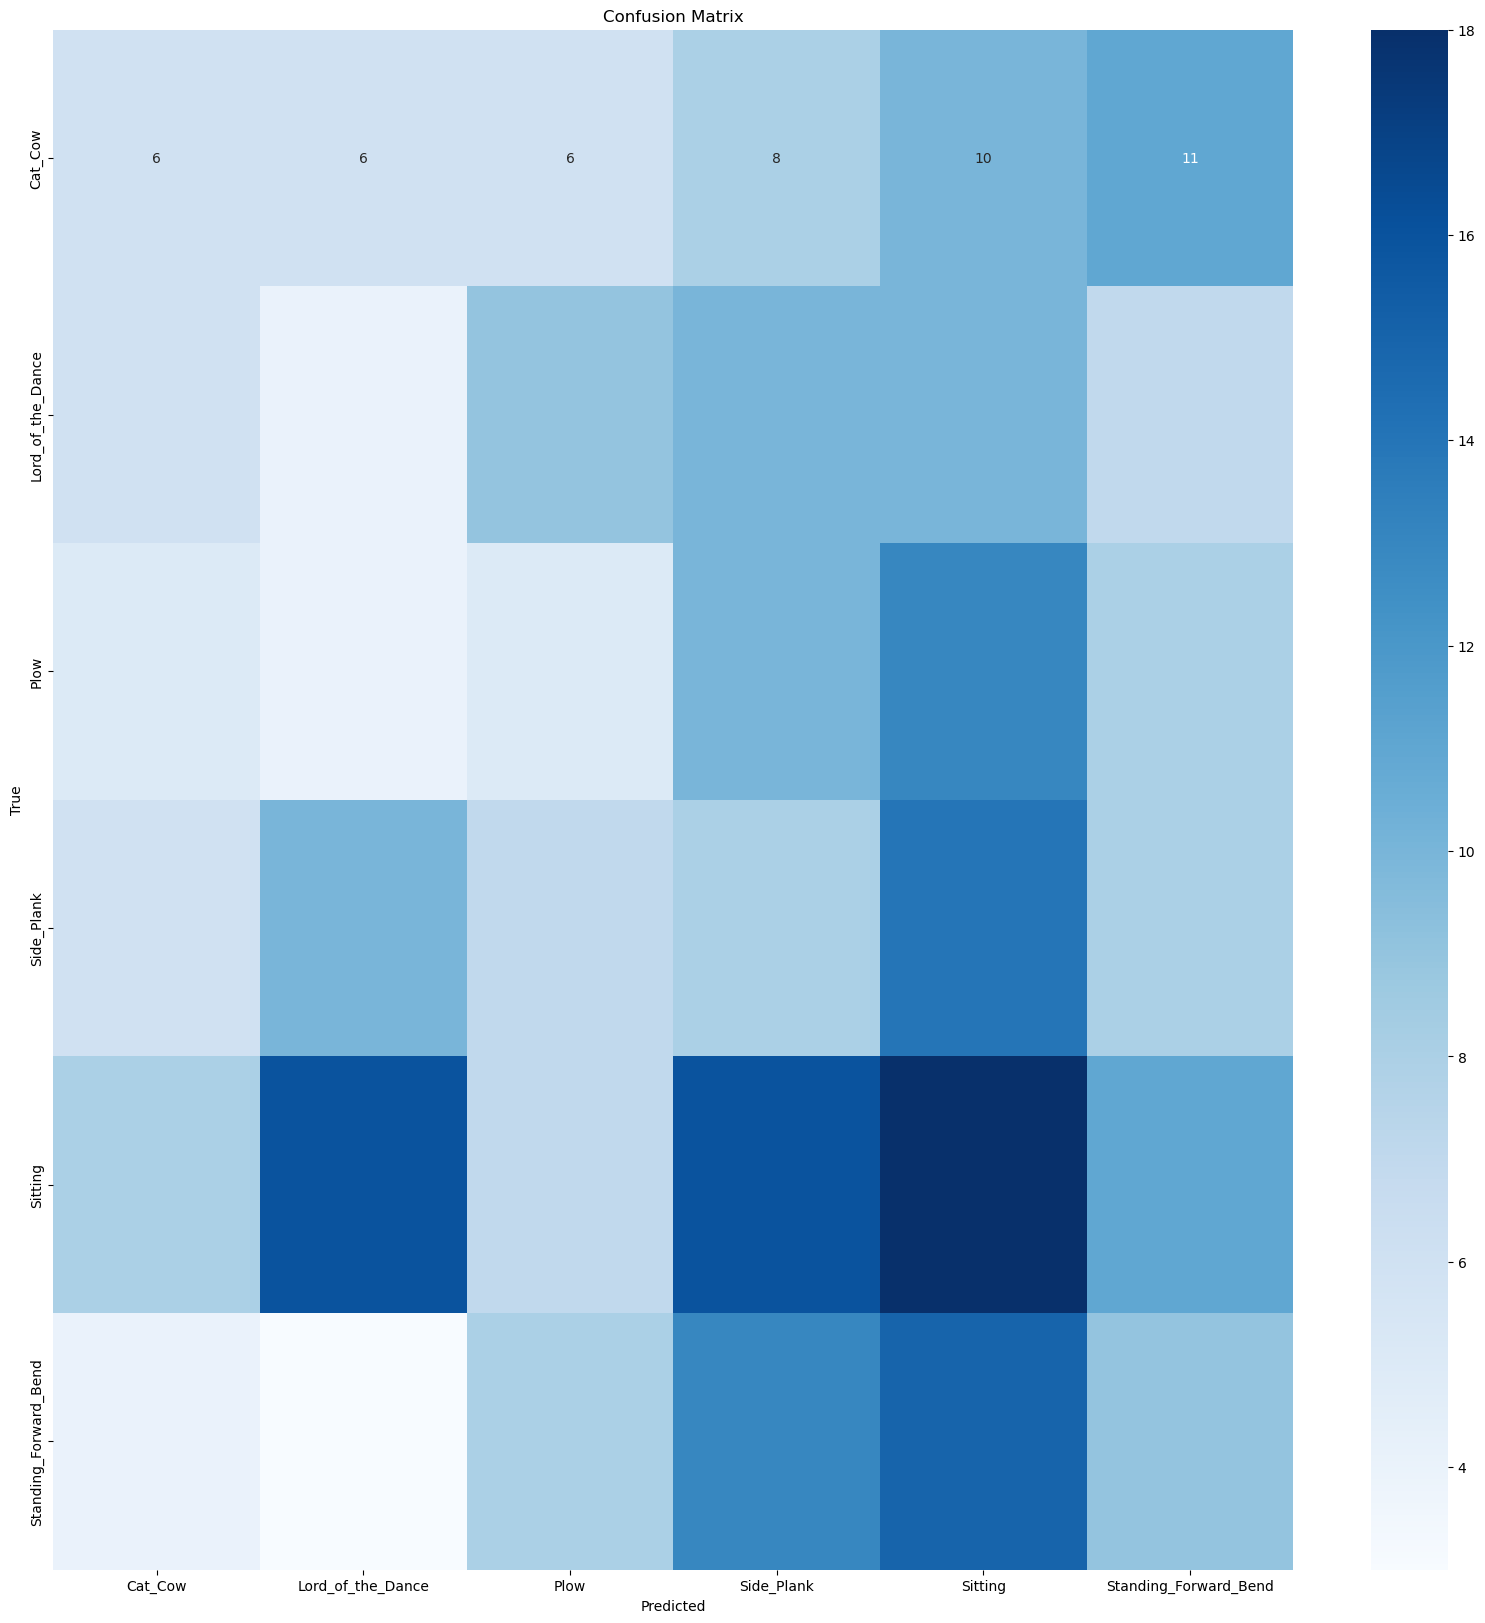

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()